In [1]:
import os
import math
import string
import numpy as np
import pandas as pd
import time
import matplotlib
import matplotlib.pyplot as plt
from time import sleep
from datetime import datetime
from math import fmod as mod
from phantasy import fetch_data



%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [12,8]

StartTime = datetime.now().strftime("%Y%m%dT%H%M%S.%f")
# filename, BCM data and fig
BCMFILENAME = "Average_BCMs_"+StartTime[:-3]+'.dat'
# settings data filepath
datafilepath = 'data/{}.json'.format(BCMFILENAME)
# segments to save settings 
segments=["LEBT", "MEBT2FS1A"]

max_BCMratio_err = 0.02 # maximum tolerance of statistical error of mean of BCM ratio

In [2]:
BCM_PVs = [
'FE_LEBT:BCM_D0989:AVGPK_RD', 
'FE_MEBT:BCM_D1055:AVGPK_RD',
'FE_MEBT:BCM_D1120:AVGPK_RD',
'FS1_CSS:BCM_D2183:AVGPK_RD',
'FS1_CSS:BCM_D2264:AVGPK_RD',
'FS1_CSS:BCM_D2353:AVGPK_RD',
##'FS1_BTS:BCM_D2449:AVGPK_RD'    
'FS1_BMS:BCM_D2519:AVGPK_RD',
'FS1_BMS:BCM_D2675:AVGPK_RD',
'FS2_BTS:BCM_D3936:AVGPK_RD',
'FS2_BBS:BCM_D4169:AVGPK_RD',
'BDS_BTS:BCM_D5521:AVGPK_RD',
'BDS_FFS:BCM_D5789:AVGPK_RD'  
]

# measure

#### initial estimate

In [3]:
n = 0
t0 = time.monotonic()
_,data = fetch_data(BCM_PVs,20,with_data=True)
n_ = data['#'].min()
n = n+n_
data = data[np.arange(n)]
data_val = data.values
BCM_ratios = data_val[1:]/data_val[0:-1]
is_enough_data = np.all(BCM_ratios.std(axis=1)/n**0.5 < max_BCMratio_err)
dt = time.monotonic() - t0

### keep measuring until error of mean is small enough

In [4]:
max_time = 60*2 #sec
while(not is_enough_data and dt < max_time):
    print(f"n_data: {n}, time: {int(dt)} sec, max error of BCM ratio: {max(BCM_ratios.std(axis=1)/n**0.5)}")
    time.sleep(20/n_ - 0.01)
    ave_,data_ = fetch_data(BCM_PVs,20,with_data=True)
    n_ = data_['#'].min()
    data_ = data_[np.arange(n_)]
    data_.columns = n+np.arange(n_)
    data = pd.concat((data,data_),axis=1)
    n = n+n_
    data_val = data.values
    BCM_ratios = data_val[1:]/data_val[0:-1]
    is_enough_data = np.all(BCM_ratios.std(axis=1)/n**0.5 < max_BCMratio_err)
    dt = time.monotonic() - t0

n_data: 100, time: 20 sec, max error of BCM ratio: 7.45070909705219
n_data: 200, time: 40 sec, max error of BCM ratio: 4.495219833128122
n_data: 300, time: 60 sec, max error of BCM ratio: 3.100914995513539
n_data: 400, time: 80 sec, max error of BCM ratio: 3.0858189454195797
n_data: 500, time: 100 sec, max error of BCM ratio: 2.677329625729453


In [5]:
avgCurr = data.mean(axis=1)
errCurr = data.std(axis=1)/n**0.5
maxScale = avgCurr.max()+errCurr.max()
minScale = avgCurr.min()+errCurr.min()

aveBCM_ratios = BCM_ratios.mean(axis=1)
errBCM_ratios = BCM_ratios.std(axis=1)/n**0.5

# plot

   BCM name           AVGPK_RD     Ratio from prev BCM
   FE_LEBT:BCM_D0989  21.509 nA       nan +/- nan %
   FE_MEBT:BCM_D1055  21.022 nA     97.74 +/- 0.04 %
   FE_MEBT:BCM_D1120  16.823 nA     80.03 +/- 0.04 %
   FS1_CSS:BCM_D2183  16.835 nA    100.08 +/- 0.08 %
   FS1_CSS:BCM_D2264  31.282 nA    185.84 +/- 0.11 %
   FS1_CSS:BCM_D2353  31.414 nA    100.43 +/- 0.04 %
   FS1_BMS:BCM_D2519   8.386 nA     26.69 +/- 0.17 %
   FS1_BMS:BCM_D2675   0.029 nA     -0.89 +/- 0.96 %
   FS2_BTS:BCM_D3936   0.009 nA     52.31 +/- 36.46 %
   FS2_BBS:BCM_D4169   0.032 nA      2.57 +/- 276.18 %
   BDS_BTS:BCM_D5521   0.029 nA    -15.28 +/- 11.98 %
   BDS_FFS:BCM_D5789  -0.009 nA     89.14 +/- 45.52 %


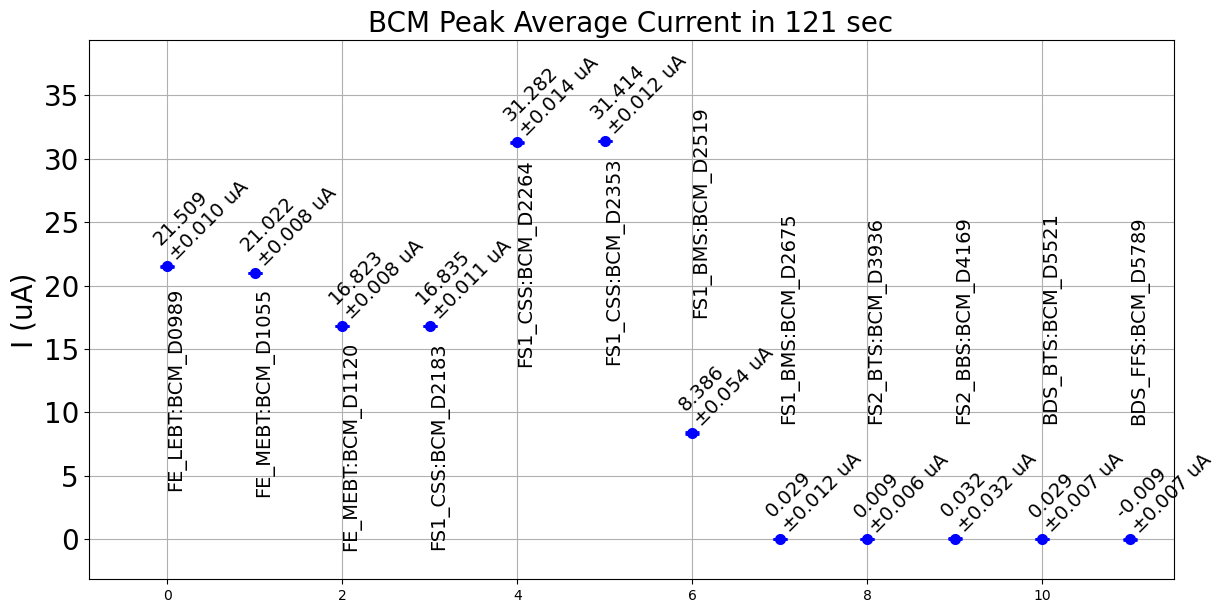

In [6]:
fig1,h1 = plt.subplots(figsize = (14,7))

markerl, steml, basel = h1.errorbar(range(len(data)), avgCurr, errCurr,
                                    marker='o',color='b',markeredgecolor='b',linestyle='', linewidth=3, capsize=5, elinewidth=3, markeredgewidth=2)
h1.set_title(f'BCM Peak Average Current in {int(dt)} sec',fontsize=20)
h1.set_xlim([-.9, len(data)-0.5]); plt.grid('on'); 
h1.set_ylim(minScale-0.1*(maxScale-minScale), maxScale+0.25*(maxScale-minScale))
h1.set_ylabel('I (uA)',fontsize=20); plt.yticks(fontsize=20)
#h1.text(-0.7, 0.95*maxScale, date, fontsize=15)

print("   BCM name           AVGPK_RD     Ratio from prev BCM")
print("======================================================")
for i in range(0,len(data)):
    if avgCurr[i] < 0.5*(minScale+maxScale):
        h1.text(i,avgCurr[i]+0.3*(maxScale-minScale),data.index[i][0:-9],fontsize=14,rotation=90)
    else:
        h1.text(i,avgCurr[i]-0.55*(maxScale-minScale),data.index[i][0:-9],fontsize=14,rotation=90)
        
    h1.text(i-0.2,avgCurr[i]+errCurr[i]+0.015*maxScale,'%.3f\n$\pm$%.3f uA'%(avgCurr[i],errCurr[i]),fontsize=14,rotation=45)
    if i==0:
        perc, err = np.nan, np.nan
    else:
        perc, err = aveBCM_ratios[i-1]*100, errBCM_ratios[i-1]*100
    print('%20s  %6.3f nA   %7.2f +/- %0.2f %%' % (data.index[i].replace(":AVGPK_RD",""),avgCurr[i],perc,err) )

FileName = "Average_peak_BCMs_"+StartTime[:-7]
data.to_csv(FileName+'.csv')
fig1.savefig(FileName[:-4]+'.png',format='png')